In [101]:
from kedro.io import DataCatalog
import yaml
import logging

logger = logging.getLogger(__name__)

with open("catalog.yml") as f:
    conf_catalog = yaml.safe_load(f)

catalog = DataCatalog.from_config(conf_catalog)

with open("parameters.yml", encoding="utf-8") as yaml_file:
    params = yaml.safe_load(yaml_file)

paa_image = catalog.load("paa_12_image")
paa_label = catalog.load("paa_12_label")
paa_roi = catalog.load("paa_12_roi")

epochs = params["tune_sam"]["epochs"]
print(len(paa_image))
print(epochs)

201
30


# Data Preprocessing: Label and Image Pairing

## Label contstruction from JSON

In [102]:
# from datasets import load_dataset
# dataset = load_dataset("nielsr/breast-cancer", split="train")
from utils.parse_label_json import LabelParser
from typing import List, Dict
import numpy as np

def prepare_masks(label_json: List[Dict]) -> Dict[str, np.ndarray]:
    masks = LabelParser.parse_json(label_json)
    
    # Debug first mask
    sample_key = list(masks.keys())[0]
    sample_mask = masks[sample_key]
    logger.info(f"Sample mask shape: {sample_mask.shape}")
    logger.info(f"Sample mask unique values: {np.unique(sample_mask)}")
    logger.info(f"Sample mask min/max: {sample_mask.min()}, {sample_mask.max()}")
    
    logger.info(f"Prepared {len(masks)} masks from Label Studio JSON")
    logger.info(f"Sample keys of masks: {list(masks.keys())[:5]}")
    
    return masks

masks = prepare_masks(paa_label)
print(len(masks))

193


## Image and Label Pairing

In [103]:
from typing import Callable, Any
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

def prepare_training_data(
    images: Dict[str, Callable[[], Image.Image]],
    masks: Dict[str, np.ndarray],
    params: Dict[str, Any],
    roi: pd.DataFrame,
) -> Dict[str, Any]:
    """Prepare images and masks for SAM fine-tuning."""
    val_split = params.get('val_split', 0.2)
    random_seed = params.get('random_seed', 42)
    
    # Create a mapping of standardized keys
    standardized_images = {
        re.sub(r'image_', '', key): value
        for key, value in images.items()
    }

    # Get sorted list of common keys
    common_keys = sorted(set(standardized_images.keys()) & set(masks.keys()), key=int)
    logger.info(f"Number of matched pairs: {len(common_keys)}")

    # Create matched arrays
    image_dict = {}
    mask_dict = {}

     # Log first image and mask sizes
    first_key = common_keys[0]
    first_image = np.array(standardized_images[first_key]().convert('RGB'))
    first_mask = masks[first_key]
    print(f"Original image shape: {first_image.shape}")
    print(f"Original mask shape: {first_mask.shape}")

    for key in common_keys:
        image = np.array(standardized_images[key]().convert('RGB'))
        mask = masks[key]
        image_dict[key] = image
        mask_dict[key] = mask

    # Split the keys for train/val
    train_keys, val_keys = train_test_split(
        common_keys,
        test_size=val_split,
        random_state=random_seed
    )

    # Create train/val dictionaries
    train_images = {k: image_dict[k] for k in train_keys}
    train_masks = {k: mask_dict[k] for k in train_keys}
    val_images = {k: image_dict[k] for k in val_keys}
    val_masks = {k: mask_dict[k] for k in val_keys}

    # Extract ROI coordinates
    sample_image = list(image_dict.values())[0]
    box_prompt = np.array([
        max(0, roi['x'].iloc[0]),
        max(0, roi['y'].iloc[0]),
        min(sample_image.shape[1], roi['x'].iloc[0] + roi['width'].iloc[0]),
        min(sample_image.shape[0], roi['y'].iloc[0] + roi['height'].iloc[0])
    ])
    
    print(f"Box prompt coordinates: {box_prompt}")

    return {
        'train': {
            'images': train_images,
            'masks': train_masks,
            'box_prompt': box_prompt
        },
        'val': {
            'images': val_images,
            'masks': val_masks,
            'box_prompt': box_prompt
        }
    }

training_data = prepare_training_data(paa_image, masks, params, paa_roi)


Original image shape: (200, 704, 3)
Original mask shape: (200, 704)
Box prompt coordinates: [496  64 658 134]


(-0.5, 703.5, 199.5, -0.5)

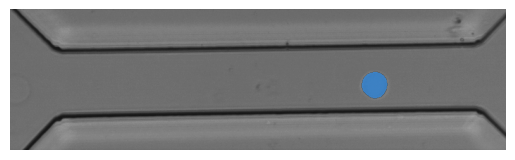

In [104]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Get the first image from training set
train_images = training_data["train"]["images"]
first_key = list(train_images.keys())[0]  # Get the first key (e.g., '86')
image = train_images[first_key]

# Get corresponding mask
train_masks = training_data["train"]["masks"]
mask = train_masks[first_key]

# Get the box prompt (same for all images)
box_prompt = training_data["train"]["box_prompt"]

# To visualize (using your existing plotting code)
fig, ax = plt.subplots()
ax.imshow(image)
show_mask(mask, ax)
ax.axis("off")

In [135]:
from transformers import SamProcessor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [136]:
class SAMDataset(Dataset):
    def __init__(self, data_dict, processor):
        self.images = data_dict['images']
        self.masks = data_dict['masks']
        self.box_prompt = data_dict['box_prompt']
        self.processor = processor
        self.keys = sorted(self.images.keys(), key=int)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        image = self.images[key]
        ground_truth_mask = self.masks[key]

        # Process both image and mask together
        inputs = self.processor(
            images=image,
            segmentation_maps=ground_truth_mask,
            input_boxes=[[self.box_prompt.tolist()]],
            return_tensors="pt"
        )
        
        # Remove batch dimension
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        
        # The processed mask will be in inputs['labels']
        inputs["ground_truth_mask"] = inputs.pop('labels')
        
        return inputs

train_dataset = SAMDataset(data_dict=training_data["train"], processor=processor)
val_dataset = SAMDataset(data_dict=training_data["val"], processor=processor)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)

# Test a single item
example = train_dataset[0]
print("Dataset item keys:", example.keys())
for k, v in example.items():
    print(f"{k}: {v.shape}")


Dataset item keys: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: torch.Size([256, 256])


In [137]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..0.8622224].


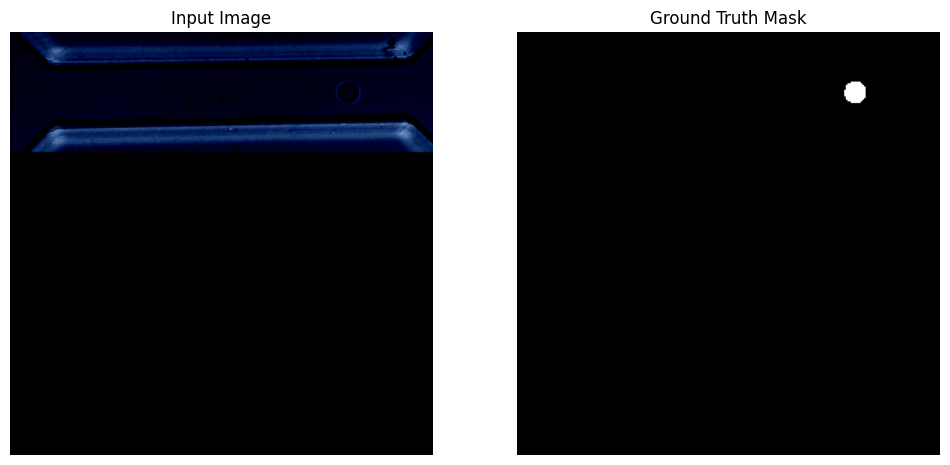

In [138]:
# Visualise the input image and input ground truth to the model side by side
# Extract the image and ground truth mask from the dataset
example = train_dataset[0]
image = example['pixel_values'].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
ground_truth_mask = example['ground_truth_mask'].numpy()

# Plot the image and ground truth mask side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

plt.show()

In [91]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [92]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [93]:
import os
# Create reporting directory if it doesn't exist
os.makedirs("reporting/sam_training", exist_ok=True)
def save_prediction_visualization(image, pred_mask, gt_mask, batch_idx, epoch):
    """Helper function to save visualization with overlays
    Args:
        image: tensor of shape [3, H, W]
        pred_mask: tensor of shape [H, W]
        gt_mask: tensor of shape [H, W]
        batch_idx: int
        epoch: int
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert image tensor to numpy and normalize for display
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    # Convert masks to binary numpy arrays
    pred_mask_np = (pred_mask.cpu().sigmoid() > 0.5).numpy().squeeze()
    gt_mask_np = gt_mask.cpu().numpy().squeeze()
    
    # Plot original with prediction overlay
    axes[0].imshow(image_np)
    show_mask(pred_mask_np, axes[0], random_color=False)  # Use blue color
    axes[0].set_title('Prediction Overlay')
    axes[0].axis('off')
    
    # Plot original with ground truth overlay
    axes[1].imshow(image_np)
    show_mask(gt_mask_np, axes[1], random_color=False)  # Use blue color
    axes[1].set_title('Ground Truth Overlay')
    axes[1].axis('off')
    
    # Plot original with both overlays
    axes[2].imshow(image_np)
    show_mask(pred_mask_np, axes[2], random_color=True)  # Prediction in random color
    show_mask(gt_mask_np, axes[2], random_color=True)    # Ground truth in different random color
    axes[2].set_title('Both Overlays')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'reporting/sam_training/epoch_{epoch}_batch_{batch_idx}.png')
    plt.close()

(1024, 1024, 3)
(256, 256)


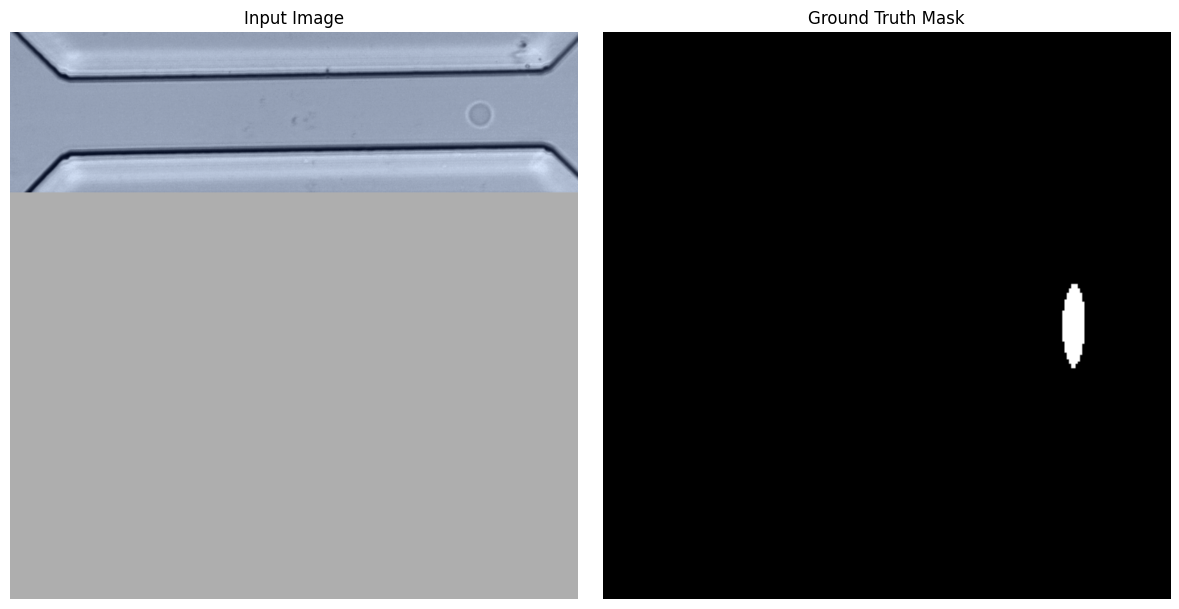

In [100]:
# Plot the model input image beside input groundtruth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot input image with proper normalization
img = batch["pixel_values"][0].cpu().numpy().transpose(1, 2, 0)
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
ax1.imshow(img)
ax1.set_title('Input Image')
ax1.axis('off')

# Plot ground truth mask
ax2.imshow(batch["ground_truth_mask"][0].cpu().numpy(), cmap='gray')
ax2.set_title('Ground Truth Mask')
ax2.axis('off')
print(img.shape)
print(batch["ground_truth_mask"][0].cpu().numpy().shape)

plt.tight_layout()

Training epoch 0: 50it [00:19,  2.63it/s]


KeyboardInterrupt: 

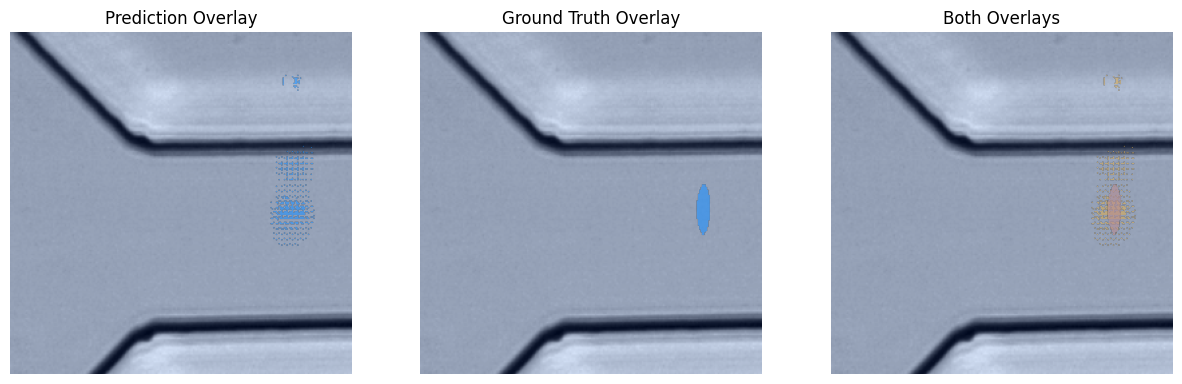

In [94]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    epoch_losses = []
    for batch_idx, batch in tqdm(enumerate(train_dataloader), desc=f"Training epoch {epoch}"):
        # forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            input_boxes=batch["input_boxes"].to(device),
            multimask_output=False
        )
        
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())

        # Visualize training predictions
        if batch_idx % 10 == 0:
            save_prediction_visualization(
                image=batch["pixel_values"][0],
                pred_mask=predicted_masks[0],
                gt_mask=ground_truth_masks[0],
                batch_idx=batch_idx,
                epoch=epoch
            )

    train_loss = mean(epoch_losses)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_epoch_losses = []
    
    with torch.no_grad():  # Disable gradient computation
        for batch_idx, batch in tqdm(enumerate(val_dataloader), desc=f"Validation epoch {epoch}"):
            # forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False
            )
            
            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            
            val_epoch_losses.append(val_loss.item())

            # Visualize validation predictions
            if batch_idx % 10 == 0:
                save_prediction_visualization(
                    image=batch["pixel_values"][0],
                    pred_mask=predicted_masks[0],
                    gt_mask=ground_truth_masks[0],
                    batch_idx=batch_idx,
                    epoch=epoch
                )

    val_loss = mean(val_epoch_losses)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'EPOCH: {epoch}')
    print(f'Training loss: {train_loss:.4f}')
    print(f'Validation loss: {val_loss:.4f}')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.close()

